Depth estimation lightweight

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
import sys
sys.path.append('../')
%cd /content/gdrive/My Drive/multi-task-refinenet/src/
from models import net

/content/gdrive/My Drive/multi-task-refinenet/src


In [ ]:
import cv2

In [ ]:
import torch
from torch.autograd import Variable

In [ ]:
# Pre-processing and post-processing constants #
CMAP = np.load('/content/gdrive/My Drive/multi-task-refinenet/src/cmap_nyud.npy')
DEPTH_COEFF = 5000. # to convert into metres
HAS_CUDA = torch.cuda.is_available()
IMG_SCALE  = 1./255
IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))
MAX_DEPTH = 8.
MIN_DEPTH = 0.
NUM_CLASSES = 40
NUM_TASKS = 1 # depth

In [ ]:
def prepare_img(img):
    return (img * IMG_SCALE - IMG_MEAN) / IMG_STD

In [ ]:
model = net(num_classes=NUM_CLASSES, num_tasks=NUM_TASKS)
if HAS_CUDA:
    _ = model.cuda()
_ = model.eval()

In [ ]:
ckpt = torch.load('/content/gdrive/My Drive/multi-task-refinenet/weights/ExpNYUD_joint.ckpt')
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [ ]:
# Figure 2-top row
img_path = '/content/gdrive/My Drive/multi-task-refinenet/examples/ExpNYUD_joint/000464.png'
img = np.array(Image.open(img_path))
gt_depth = np.array(Image.open('/content/gdrive/My Drive/multi-task-refinenet/examples/ExpNYUD_joint/depth_gt_000464.png'))

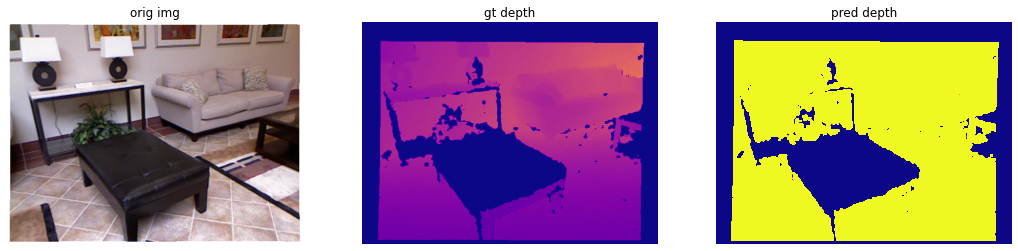

In [ ]:
with torch.no_grad():
    img_var = Variable(torch.from_numpy(prepare_img(img).transpose(2, 0, 1)[None]), requires_grad=False).float()
    if HAS_CUDA:
        img_var = img_var.cuda()
    depth = model(img_var)
    depth = cv2.resize(depth[0][0].cpu().data.numpy(),
                       img.shape[:2][::-1],
                       interpolation=cv2.INTER_CUBIC)
    depth = np.abs(depth)
plt.figure(figsize=(18, 12))
plt.subplot(131)
plt.imshow(img)
plt.title('orig img')
plt.axis('off')

plt.subplot(132)
plt.imshow(gt_depth / DEPTH_COEFF, cmap='plasma', vmin=MIN_DEPTH, vmax=MAX_DEPTH)
plt.title('gt depth')
plt.axis('off')

plt.subplot(133)
plt.imshow(gt_depth, cmap='plasma', vmin=MIN_DEPTH, vmax=MAX_DEPTH)
plt.title('pred depth')
plt.axis('off');